# Problem

Consider the following problem:

> Suppose we keep rolling a die and after each roll, we write down the total sum of all previous die rolls. For example, if you roll a 5, write down 5. If you then roll a 4, write down 9, etc. Let $f(n)$ be the likelihood that the number $n$ is written down at some point. What is the limit of $f(n)$ as $n$ goes to infinity ?

In this notebook, we show how this problem can be solved numerically using the Fourier transform method. There are probably easier solutions (e.g. using recursion) but this is a great example of how the characteristic function can be used to solve probability problems.

# Solution

Assume we have a fair six-sided die. The probability of obtaining a value $x_k$ on a single roll is denoted

\begin{equation}
    P_X(x_k) = p_k.
\end{equation}

The probability density function is

\begin{equation}
    f_X(x) = \sum_k p_k \delta(x - x_k)
\end{equation}

where $\delta(.)$ is the Dirac's delta function.

We now want the characteristic function. We obtain it by applying the Fourier transform to $f_X(x)$:

\begin{equation}
    \varphi_X(\xi) = \mathscr{F}_{X \to \xi} \left[ f_X(x) \right] = \int_{\mathbb{R}} f_X(x)e^{i \xi x} = \sum_k p_k e^{i \xi x_k}
\end{equation}

where $i$ is the imaginary unit. 

We have $k = 1, 2, ..., 6$ and $x_k = k$. Also, $p_k = \frac{1}{6}, \; \forall k$. Therefore, the characteristic function for a single roll is

\begin{equation}
    \varphi_X(\xi) = \frac{1}{6} \left( e^{i\xi} + e^{i2\xi} + e^{i3\xi} + e^{i4\xi} + e^{i5\xi} + e^{i6\xi} \right).
\end{equation}

Now we want to find the characteristic function for the sum over $n$ rolls. Consider $Y$ such that 

\begin{equation}
    Y = \sum_{j=1}^n X_j = X_1 + X_2 + ... + X_n.
\end{equation}

The joint probability density function is

\begin{equation}
    f_{X_1...X_n}(x_1...x_n) = \prod_{j = 1}^n f_{X_j}(x_j) = f_{X_1}(x_1)...f_{X_n}(x_n).
\end{equation}

Therefore, the characteristic function is 

\begin{align}
    \varphi_Y(\xi) = \mathbb{E} \left[ e^{i \xi y} \right] &= \int_{\mathbb{R}} ... \int_{\mathbb{R}} e^{i \xi \sum_{j = 1}^n x_j} \prod_{j = 1}^n f_{X_j}(x_j) dx_1 ... dx_n \\
    & = \prod_{j = 1}^n \int_{\mathbb{R}} e^{i \xi x_j} f_{X_j}(x_j)dx_j = \prod_{j = 1}^n \varphi_{X_j}(\xi).
\end{align}

Because all the $X_j$ are i.i.d. (independent and identically distributed), we have

\begin{equation}
    \varphi_Y(\xi) = \varphi_X^n(\xi) = \frac{1}{6^n} \left( e^{i\xi} + e^{i2\xi} + e^{i3\xi} + e^{i4\xi} + e^{i5\xi} + e^{i6\xi} \right)^n.
\end{equation}

Using the above characteristic function for $Y$, we can already find the probability that the sum obtained by rolling $n$ dice is equal to a number $m$. Taking the inverse Fourier transform, we obtain

\begin{align}
    P(Y = m) &= \frac{1}{2 \pi} \int_{- \pi}^{\pi} e^{-i \xi m} \frac{1}{6^n} \left( e^{i\xi} + e^{i2\xi} + e^{i3\xi} + e^{i4\xi} + e^{i5\xi} + e^{i6\xi} \right)^n d\xi \\
    &= \frac{1}{2 \pi} \int_{- \pi}^{\pi} e^{-i \xi m} \frac{1}{6^n} \left( \sum_{k = 1}^6 e^{i\xi k} \right)^n d\xi.
\end{align}

Note that the bounds of the integral do not need to go from $-\infty$ to $+\infty$ because the integrand is oscillatory. The integration is easily done numerically. Let's create a function which computes the probability that the sum over $n$ rolls of a $k$-sided die is $m$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def proba_sum_die_rolls(n_rolls, target_number, die_faces=6):
    n = n_rolls # number of dice rolled (or number of successive rolls of the same die)
    m = target_number    
    dxi = (2*np.pi)/1000
    xi = np.linspace(-np.pi, np.pi, 1001)
    
    cf_x = 0    
    for k in range(1, die_faces + 1):
        cf_x += np.exp(1j*k*xi)
    cf_x = cf_x/k
    p = np.power(cf_x, n) * 1/(2*np.pi) * np.exp(-1j*m*xi)
    p = np.real(np.trapz(p*dxi))
    
    return p

Let's try it with an example. Suppose we roll 2 dice and want to know the probability that the sum of the dice is 12. Intuitively, we know the answer is $\frac{1}{36}$ because there is only one combination that sums up to 12 (i.e., 6 and 6) out of the 36 possibilities.

In [2]:
# Test with 2 dice and a target number of 12
res = proba_sum_die_rolls(2, 12)

print("The result is " + str(round(res, 10)) + ".")
print(round(1/36, 10) == round(res, 10)) 

The result is 0.0277777778.
True


As expected, the result is equal to $\frac{1}{36}$.

In order to solve our original problem, we need to sum the probabilities over the rolls. If $m$ is our target number, the maximum number of rolls that can result in a sum equal to $m$ is $m$ rolls (we get 1 on each roll). Therefore, we find the solution by summing the probabilities for each number of rolls from 1 to $m$. Taking the limit as $m$ goes to infinity, we obtain the solution 

\begin{equation}
    \lim_{n \to \infty} f(n) = \lim_{m \to \infty} \sum_{n = 1}^m \frac{1}{2 \pi} \int_{- \pi}^{\pi} e^{-i \xi m} \frac{1}{6^n} \left( \sum_{k = 1}^6 e^{i\xi k} \right)^n d\xi
\end{equation}

In order to find the solution numerically, we plot the result for different values of $m$ and investigate if it converges. Let's try with $m = 100$.

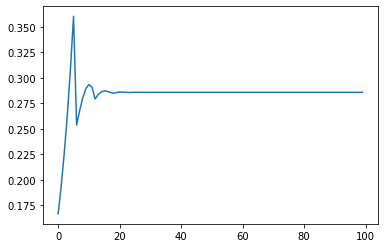

In [3]:
# Test if the algorithm converges with m = 100
m = 100
res_list = []

# For each value of m, sum the probabilities of obtaining m for each value of n (from 1 to n)
for m in range(1, 101):
    res = 0
    for n in range(1, m+1):
        res += proba_sum_die_rolls(n, m)
    res_list.append(res)

# Plot for visual inspection of convergence    
plt.plot(res_list);

The algorithm seems to converge. Let's print the last values that we obtained.

In [4]:
print(res_list[-5:])

[0.2857142857142768, 0.2857142857142979, 0.2857142857143002, 0.2857142857142904, 0.28571428571428337]


Rounded to 10 digits, the algorithm has converged to a value of 0.2857142857. It is actually equal to $\frac{2}{7}$ and this is the solution to our problem.